Author: yanjun zhang
## Concise
## 1: Start

Source from book "Abali - 2017 - Computational Reality" P119

import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

In [1]:
from my_imports import *

# calculate how long time the simulation it is
start_time = time.time()

# mesh-size, contact area coefficient
mesh_min = 3
mesh_max = 15
c_contact = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r = 224
v_vehicle = 160
c_acc = 1

# calling local functions to get all parameters
(dt, P, g, num_steps, h, radiation, v_angular, Ti, Tm, S_rub_circle, t, rho, c, k, t_brake, 
S_total,) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)

print("1: Total tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)


DOLFINx version: 0.8.0
1: Total tims is  49.89 s
2: Total numb steps is  608


## 2: Mesh

In [2]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)
mesh_filename2 = "m-{}".format(mesh_name)

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3 )
else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist, start building:")
    mesh_brake_disc(mesh_min, mesh_max, mesh_filename2, 'tetra')
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3 )

# Define variational problem, CG is Lagrabge
V = fem.functionspace(domain, ("CG", 1))

# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs=[])
    return problem.solve()

# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V, DG is discontinuous Lagrange
Q = fem.functionspace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init, V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1

## bc_disc is zero, no any dirichlete boundary condition, z = 100, not exist
bc_disc = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 100)) 

bc = fem.dirichletbc(
    PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V
)
np.set_printoptions(threshold=np.inf)

import meshio

mesh1 = meshio.read(mesh_filename1)
total_elements = sum(len(cells.data) for cells in mesh1.cells)

The file 'm-3-15.msh' exists, start creat now:
Info    : Reading 'm-3-15.msh'...
Info    : 168 entities
Info    : 4281 nodes
Info    : 14875 elements
Info    : Done reading 'm-3-15.msh'



## 3: Setup 


In [4]:
# create xdmf file, for paraview
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition
x_co, y_co = get_rub_coordinate()

common_indices3, facet_markers3, sorted_indices3 = target_facets (domain, x_co, y_co, S_rub_circle )

facet_tag = meshtags (domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3] )

ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

## 4: Variational equation


In [5]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init, V)  ##give temperature to all elements
t = 0
xdmf.write_function(uh, t)

# u = trial function, solution what we want to know
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))  ## heat source is 0
n_vector = FacetNormal(domain)

F = (
    (rho * c) / dt[0] * inner(u, v) * dx
    + k * inner(grad(u), grad(v)) * dx
    + h * inner(u, v) * ds(200)    #200 is the contact area, details are in function of target_facets.
    + radiation * inner(u**4, v) * ds(200)
    - (
        inner(f, v) * dx
        + (rho * c) / dt[0] * inner(u_n, v) * dx
        + h * Tm * v * ds(200)
        + radiation * (Tm**4) * v * ds(200)
    )
)


for i in list(range(1, 19)):
    # before 2024/5/16
    F += ( 
          + inner(g[0], v) * ds(10 * i) 
          - h * inner( u, v) * ds(10 * i)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * i) 
         )

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert converged

## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl

pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(
    title_font_size=25,
    label_font_size=20,
    color="black",
    position_x=0.1,
    position_y=0.8,
    width=0.8,
    height=0.1,
)
renderer = plotter.add_mesh(
    warped,
    show_edges=True,
    lighting=False,
    cmap=viridis,
    scalar_bar_args=sargs,
    # clim=[0, max(uh.x.array)])
    clim=[0, 200],
)

2024-10-15 10:38:06.809 (  23.686s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:06.837 (  23.714s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:06.843 (  23.720s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0195749 (tol = 1e-10) r (rel) = 4.98623e-06(tol = 1e-06)
2024-10-15 10:38:06.853 (  23.730s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:06.859 (  23.736s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 9.74549e-08 (tol = 1e-10) r (rel) = 2.48243e-11(tol = 1e-06)
2024-10-15 10:38:06.859 (  23.737s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 14 linear solver iterations.


# Initial deformation

In [6]:
VT = fem.functionspace(domain, ("CG", 1))              #define the finite element function space

T_, dT = ufl.TestFunction(VT), ufl.TrialFunction(VT)  # T_ is the test function, like v
Delta_T = fem.Function(VT, name="Temperature_variation")
aT = ufl.dot(ufl.grad(dT), ufl.grad(T_)) * ufl.dx     # a is grad T, grad T_, like grad u, grad v
LT = fem.Constant(domain, 0.0) * T_ * ufl.dx          # L is 0, o*v, v is T_
bc_disc_T = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 50))

def contact(x):
    return np.isclose(x[2],50)
contact_dofs_T = fem.locate_dofs_geometrical(VT, contact)  
bcT= [ fem.dirichletbc( 64.0, contact_dofs_T, VT )  ]

problem = fem.petsc.LinearProblem(aT, LT, u=Delta_T, bcs=bcT)
problem.solve()

2024-10-15 10:38:11.205 (  28.083s) [main            ]      dofmapbuilder.cpp:166   INFO| Checking required entities per dimension
2024-10-15 10:38:11.205 (  28.083s) [main            ]      dofmapbuilder.cpp:264   INFO| Cell type:0, dofmap:12168x4
2024-10-15 10:38:11.206 (  28.083s) [main            ]      dofmapbuilder.cpp:320   INFO| Global index computation
2024-10-15 10:38:11.206 (  28.083s) [main            ]      dofmapbuilder.cpp:637   INFO| Got 1 index_maps
2024-10-15 10:38:11.206 (  28.084s) [main            ]      dofmapbuilder.cpp:644   INFO| Get global indices
2024-10-15 10:38:11.209 (  28.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:11.209 (  28.087s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-15 10:38:11.209 (  28.087s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (2,0)
2024-10-15 10:38:11.210 (  28.088s) 

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, tetrahedron, 1, equispaced, unset, False, float64, []), (3,)), 0), Basix element (P, tetrahedron, 1, gll_warped, unset, False, float64, [])), 5)

## 5: Solution


In [7]:
T_array = [(0, [Ti for _ in range(len(u.x.array))])]
total_degree = 0

for i in range(30):
    t += dt[i]

    x_co, y_co = rub_rotation(x_co, y_co, angular_r)  # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step

    sys.stdout.write("\r1: Rotation has applied for {} degree. ".format(total_degree))
    sys.stdout.write("2: Current time is " + str(round(t, 1)) + " s. ")
    sys.stdout.write("3: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    common_indices3, facet_markers3, sorted_indices3 = target_facets(
        domain, x_co, y_co, S_rub_circle
    )
    facet_tag = meshtags(
        domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
    )
    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

    F = (
        (rho * c) / dt[i] * inner(u, v) * dx
        + k * inner(grad(u), grad(v)) * dx
        + h * inner(u, v) * ds(200)
        + radiation * inner(u**4, v) * ds(200)
        - (
            inner(f, v) * dx
            + (rho * c) / dt[i] * inner(u_n, v) * dx
            + h * Tm * v * ds(200)
            + radiation * (Tm**4) * v * ds(200)
        )
    )

    for j in list(range(1, 19)):
        #F += -k * dot(grad(u) * v, n_vector) * ds(10 * j) - inner(g[i], v) * ds(10 * j)
        F += ( 
          - inner(g[i], v) * ds(10 * j) 
          - h * inner( u, v) * ds(10 * j)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * j) 
         )    

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6

    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write("1: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array

    T_array.append((t, u.x.array.copy()))
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    # warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    #plotter.update_scalars(u.x.array, render=False)
    #plotter.write_frame()

plotter.close()
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
save_t_T(csv_name, T_array)

1: Rotation has applied for 224 degree. 2: Current time is 0.0 s. 3: Completion is 0.1 %. 

2024-10-15 10:38:12.746 (  29.623s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-15 10:38:12.746 (  29.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-15 10:38:12.746 (  29.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-15 10:38:12.746 (  29.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-15 10:38:12.746 (  29.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-15 10:38:12.746 (  29.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-15 10:38:12.747 (  29.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-15 10:38:12.747 (  29.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 448 degree. 2: Current time is 0.1 s. 3: Completion is 0.2 %. 

2024-10-15 10:38:14.152 (  31.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:14.152 (  31.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:14.153 (  31.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:14.153 (  31.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:14.155 (  31.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:14.161 (  31.038s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:14.192 (  31.069s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:14.225 (  31.102s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 672 degree. 2: Current time is 0.1 s. 3: Completion is 0.2 %. 

2024-10-15 10:38:15.485 (  32.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:15.486 (  32.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:15.487 (  32.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:15.487 (  32.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:15.489 (  32.366s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:15.497 (  32.374s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:15.516 (  32.393s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:15.543 (  32.420s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 896 degree. 2: Current time is 0.2 s. 3: Completion is 0.3 %. 

2024-10-15 10:38:16.786 (  33.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:16.786 (  33.664s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:16.787 (  33.664s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:16.787 (  33.664s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:16.789 (  33.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:16.795 (  33.673s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:16.811 (  33.689s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:16.838 (  33.716s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1120 degree. 2: Current time is 0.2 s. 3: Completion is 0.4 %. 

2024-10-15 10:38:17.914 (  34.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:17.914 (  34.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:17.915 (  34.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:17.915 (  34.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:17.917 (  34.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:17.923 (  34.800s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:17.935 (  34.813s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:17.971 (  34.849s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1344 degree. 2: Current time is 0.2 s. 3: Completion is 0.5 %. 

2024-10-15 10:38:19.259 (  36.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:19.259 (  36.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:19.260 (  36.138s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:19.260 (  36.138s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:19.262 (  36.140s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:19.268 (  36.146s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:19.301 (  36.179s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:19.333 (  36.210s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1568 degree. 2: Current time is 0.3 s. 3: Completion is 0.6 %. 

2024-10-15 10:38:20.612 (  37.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:20.612 (  37.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:20.614 (  37.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:20.614 (  37.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:20.616 (  37.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:20.621 (  37.499s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:20.639 (  37.516s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:20.664 (  37.542s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1792 degree. 2: Current time is 0.3 s. 3: Completion is 0.7 %. 

2024-10-15 10:38:21.871 (  38.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:21.872 (  38.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:21.873 (  38.750s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:21.873 (  38.750s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:21.874 (  38.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:21.880 (  38.757s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:21.901 (  38.779s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:21.942 (  38.819s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2016 degree. 2: Current time is 0.4 s. 3: Completion is 0.7 %. 

2024-10-15 10:38:23.133 (  40.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:23.133 (  40.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:23.134 (  40.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:23.134 (  40.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:23.136 (  40.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:23.142 (  40.020s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:23.156 (  40.034s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:23.184 (  40.062s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2240 degree. 2: Current time is 0.4 s. 3: Completion is 0.8 %. 

2024-10-15 10:38:24.391 (  41.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:24.391 (  41.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:24.392 (  41.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:24.392 (  41.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:24.395 (  41.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:24.405 (  41.282s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:24.437 (  41.314s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:24.463 (  41.341s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2464 degree. 2: Current time is 0.4 s. 3: Completion is 0.9 %. 

2024-10-15 10:38:25.609 (  42.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:25.609 (  42.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:25.610 (  42.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:25.610 (  42.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:25.611 (  42.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:25.619 (  42.496s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:25.635 (  42.512s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:25.667 (  42.545s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2688 degree. 2: Current time is 0.5 s. 3: Completion is 1.0 %. 

2024-10-15 10:38:27.206 (  44.083s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:27.206 (  44.083s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:27.207 (  44.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:27.207 (  44.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:27.209 (  44.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:27.225 (  44.103s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:27.253 (  44.131s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:27.282 (  44.160s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2912 degree. 2: Current time is 0.5 s. 3: Completion is 1.1 %. 

2024-10-15 10:38:28.538 (  45.415s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:28.538 (  45.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:28.539 (  45.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:28.539 (  45.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:28.541 (  45.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:28.550 (  45.428s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:28.569 (  45.447s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:28.608 (  45.485s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3136 degree. 2: Current time is 0.6 s. 3: Completion is 1.2 %. 

2024-10-15 10:38:29.768 (  46.645s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:29.768 (  46.645s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:29.769 (  46.646s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:29.769 (  46.646s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:29.771 (  46.648s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:29.776 (  46.653s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:29.796 (  46.673s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:29.849 (  46.726s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3360 degree. 2: Current time is 0.6 s. 3: Completion is 1.2 %. 

2024-10-15 10:38:31.316 (  48.193s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:31.316 (  48.194s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:31.317 (  48.194s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:31.317 (  48.195s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:31.319 (  48.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:31.324 (  48.202s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:31.340 (  48.217s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:31.387 (  48.264s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3584 degree. 2: Current time is 0.7 s. 3: Completion is 1.3 %. 

2024-10-15 10:38:32.616 (  49.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:32.616 (  49.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:32.617 (  49.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:32.617 (  49.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:32.620 (  49.498s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:32.627 (  49.504s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:32.646 (  49.524s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:32.693 (  49.571s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3808 degree. 2: Current time is 0.7 s. 3: Completion is 1.4 %. 

2024-10-15 10:38:33.680 (  50.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:33.681 (  50.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:33.681 (  50.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:33.681 (  50.559s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:33.682 (  50.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:33.688 (  50.565s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:33.701 (  50.579s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:33.722 (  50.599s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4032 degree. 2: Current time is 0.7 s. 3: Completion is 1.5 %. 

2024-10-15 10:38:34.694 (  51.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:34.694 (  51.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:34.695 (  51.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:34.695 (  51.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:34.697 (  51.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:34.698 (  51.576s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:34.723 (  51.600s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:34.762 (  51.640s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4256 degree. 2: Current time is 0.8 s. 3: Completion is 1.6 %. 

2024-10-15 10:38:35.720 (  52.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:35.720 (  52.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:35.722 (  52.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:35.722 (  52.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:35.724 (  52.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:35.729 (  52.607s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:35.753 (  52.630s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:35.787 (  52.665s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4480 degree. 2: Current time is 0.8 s. 3: Completion is 1.7 %. 

2024-10-15 10:38:36.861 (  53.738s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:36.861 (  53.739s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:36.862 (  53.739s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:36.862 (  53.739s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:36.864 (  53.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:36.869 (  53.747s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:36.887 (  53.765s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:36.918 (  53.795s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4704 degree. 2: Current time is 0.9 s. 3: Completion is 1.7 %. 

2024-10-15 10:38:38.007 (  54.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:38.008 (  54.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:38.008 (  54.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:38.008 (  54.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:38.010 (  54.887s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:38.016 (  54.893s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:38.035 (  54.913s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:38.070 (  54.947s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4928 degree. 2: Current time is 0.9 s. 3: Completion is 1.8 %. 

2024-10-15 10:38:39.311 (  56.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:39.311 (  56.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:39.311 (  56.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:39.311 (  56.189s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:39.314 (  56.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:39.321 (  56.199s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:39.343 (  56.220s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:39.396 (  56.273s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5152 degree. 2: Current time is 0.9 s. 3: Completion is 1.9 %. 

2024-10-15 10:38:40.784 (  57.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:40.784 (  57.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:40.785 (  57.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:40.785 (  57.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:40.787 (  57.664s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:40.793 (  57.670s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:40.814 (  57.691s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:40.861 (  57.739s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5376 degree. 2: Current time is 1.0 s. 3: Completion is 2.0 %. 

2024-10-15 10:38:42.267 (  59.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:42.268 (  59.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:42.268 (  59.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:42.269 (  59.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:42.270 (  59.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:42.276 (  59.154s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:42.295 (  59.173s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:42.337 (  59.215s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5600 degree. 2: Current time is 1.0 s. 3: Completion is 2.1 %. 

2024-10-15 10:38:43.591 (  60.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:43.592 (  60.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:43.592 (  60.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:43.593 (  60.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:43.594 (  60.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:43.600 (  60.477s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:43.617 (  60.495s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:43.643 (  60.520s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5824 degree. 2: Current time is 1.1 s. 3: Completion is 2.2 %. 

2024-10-15 10:38:44.718 (  61.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:44.718 (  61.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:44.718 (  61.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:44.719 (  61.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:44.720 (  61.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:44.726 (  61.604s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:44.749 (  61.626s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:44.773 (  61.650s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6048 degree. 2: Current time is 1.1 s. 3: Completion is 2.3 %. 

2024-10-15 10:38:46.004 (  62.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:46.004 (  62.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:46.005 (  62.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:46.005 (  62.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:46.007 (  62.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:46.013 (  62.890s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:46.027 (  62.904s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:46.051 (  62.928s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6272 degree. 2: Current time is 1.1 s. 3: Completion is 2.3 %. 

2024-10-15 10:38:47.150 (  64.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:47.150 (  64.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:47.151 (  64.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:47.151 (  64.028s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:47.153 (  64.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:47.170 (  64.047s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:47.207 (  64.084s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:47.270 (  64.148s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6496 degree. 2: Current time is 1.2 s. 3: Completion is 2.4 %. 

2024-10-15 10:38:48.751 (  65.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:48.752 (  65.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:48.752 (  65.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:48.752 (  65.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:48.754 (  65.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:48.759 (  65.637s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:48.778 (  65.655s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:48.810 (  65.687s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6720 degree. 2: Current time is 1.2 s. 3: Completion is 2.5 %. 

2024-10-15 10:38:50.223 (  67.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:50.224 (  67.101s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:50.225 (  67.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:50.225 (  67.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:50.227 (  67.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:50.232 (  67.110s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:50.248 (  67.125s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:50.274 (  67.152s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 2.5 %. 

2024-10-15 10:38:51.319 (  68.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:51.319 (  68.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:51.320 (  68.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:51.320 (  68.197s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-15 10:38:51.321 (  68.199s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-15 10:38:51.327 (  68.205s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-15 10:38:51.344 (  68.222s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-15 10:38:51.374 (  68.252s) [main            ]              petsc.cpp:700   INFO| PETS


t and T have been successfully saved as Result_T-s-608-d-224-m-3-15-c-1-e-14875.csv


In [9]:
#######try to make domain only for brake pad.

E = fem.Constant(domain, 50e3)             # Elastic module
nu = fem.Constant(domain, 0.2)             # Poission ratio
gdim = domain.geometry.dim

mu = E / 2 / (1 + nu)                      # Shear modulus
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)   # Lame parameters
alpha = fem.Constant(domain, 1e-5)         # Thermal expansion coefficient

f1 = fem.Constant(domain, (0.0, 0.0, 0.0))       # O for external force

def eps(v):                                # epsilon, strain, the deforamtion, dy/y 
    return ufl.sym(ufl.grad(v))

def sigma(v, Delta_T):                     # sigmathis is sigma
    return (lmbda * ufl.tr(eps(v)) - alpha * (3 * lmbda + 2 * mu) * Delta_T 
    ) * ufl.Identity(gdim)  + 2.0 * mu * eps(v)     # here braces is important, can not be in above line

Vu = fem.functionspace(domain, ("CG", 1, (gdim,))) 
du = ufl.TrialFunction(Vu)
u_ = ufl.TestFunction(Vu)

Wint = ufl.inner(sigma(du, Delta_T), eps(u_)) * ufl.dx  # here du is unkown
aM = ufl.lhs(Wint)                                      # Wint is long and lhs can help to distinguish unkown and know.
LM = ufl.rhs(Wint) + ufl.inner(f1, u_) * ufl.dx          # knows parameters are in lhs

def up_side(x):
    return np.logical_or(np.isclose(x[2], 53), np.isclose(x[2], 83))
    
up_dofs_u = fem.locate_dofs_geometrical(Vu, up_side) # lateral sides of domain
bcu = [fem.dirichletbc(np.zeros((gdim,)), up_dofs_u, Vu)]  # displacement Vu is fixed in lateral sides

2024-10-15 10:39:53.447 ( 130.325s) [main            ]      dofmapbuilder.cpp:166   INFO| Checking required entities per dimension
2024-10-15 10:39:53.448 ( 130.325s) [main            ]      dofmapbuilder.cpp:264   INFO| Cell type:0, dofmap:12168x4
2024-10-15 10:39:53.448 ( 130.325s) [main            ]      dofmapbuilder.cpp:320   INFO| Global index computation
2024-10-15 10:39:53.448 ( 130.325s) [main            ]      dofmapbuilder.cpp:637   INFO| Got 1 index_maps
2024-10-15 10:39:53.448 ( 130.326s) [main            ]      dofmapbuilder.cpp:644   INFO| Get global indices


In [10]:
u = fem.Function(Vu, name="Displacement")
problem = fem.petsc.LinearProblem(aM, LM, u=u, bcs=bcu)
problem.solve()

2024-10-15 10:39:55.458 ( 132.335s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0


Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, tetrahedron, 1, equispaced, unset, False, float64, []), (3,)), 0), blocked element (Basix element (P, tetrahedron, 1, gll_warped, unset, False, float64, []), (3,))), 6)

# 6: Post process

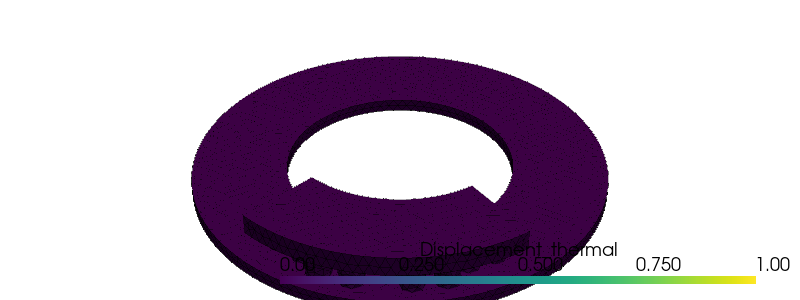

In [17]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(Vu)                # get mesh data
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry) # plot grid
u_3D = np.zeros((u_geometry.shape[0], 3))
u_3D[:, :3] = u.x.array.reshape(-1, 3)
u_grid.point_data["Displacement_thermal"] = u_3D
u_grid.set_active_vectors("Displacement_thermal")
warped = u_grid.warp_by_vector("Displacement_thermal", factor=10000)

plotter = pyvista.Plotter()
plotter.window_size = (800, 300)
plotter.add_mesh(warped)
edges = warped.extract_all_edges()
plotter.add_mesh(edges, color="k", line_width=1, opacity=0.5)

plotter.zoom_camera(2)
plotter.show()